In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id

from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.models import TFTacotron2

import IPython.display as ipd

In [2]:
with open('../examples/tacotron2/conf/tacotron2.v1.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [3]:
config = Tacotron2Config(**config["tacotron2_params"])

In [4]:
tacotron2 = TFTacotron2(config=config, training=False, name="tacotron2")

In [5]:
tacotron2._build()

In [6]:
tacotron2.summary()

Model: "tacotron2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (TFTacotronEncoder)  multiple                  8218624   
_________________________________________________________________
decoder_cell (TFTacotronDeco multiple                  18246402  
_________________________________________________________________
post_net (TFTacotronPostnet) multiple                  5460480   
_________________________________________________________________
residual_projection (Dense)  multiple                  41040     
Total params: 31,966,546
Trainable params: 31,956,306
Non-trainable params: 10,240
_________________________________________________________________


In [7]:
tacotron2.load_weights("../examples/tacotron2/checkpoints/model-100000.h5")

In [8]:
input_text = "Recent research at Harvard has shown meditating\
for as little as 8 weeks, can actually increase the grey matter in the \
parts of the brain responsible for emotional regulation, and learning."

In [9]:
input_ids = LJSpeechProcessor(None, "english_cleaners").text_to_sequence(input_text.lower())
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)  # eos.

In [10]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        input_ids=np.expand_dims(input_ids, 0),
        input_lengths=np.array([len(input_ids)]),
        speaker_ids=tf.convert_to_tensor(np.array([0]), dtype=tf.int32),
        maximum_iterations=tf.constant(4000, dtype=tf.int32),
        use_window_mask=False,
        win_front=6,
        win_back=6,
)

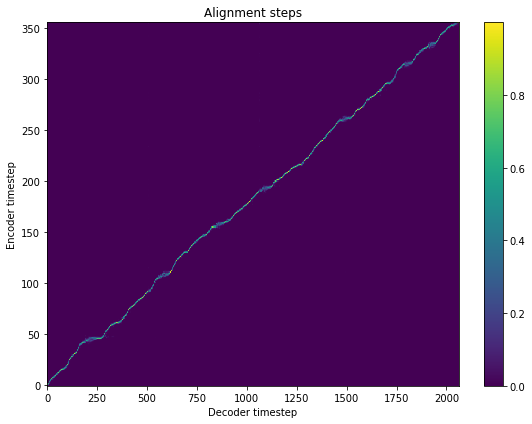

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

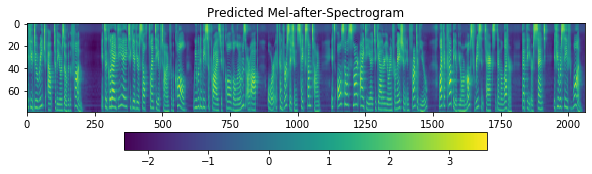

In [12]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()